## Import

In [1]:
import pandas as pd
import requests
from urllib.request import urlopen
import json
from pandas import json_normalize
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
# ignore warnings
import warnings ; warnings.filterwarnings('ignore')

## Read Data

In [2]:
# 삼성전자의 장부 정보를 불러온다.
key = '3510098a70675da8c7a834ab9a8df850762900a0'
code = '00126380'
years = [2019, 2020, 2021, 2022, 2023]
report_codes = [11013, 11012, 11014, 11011]

urls = [f"https://opendart.fss.or.kr/api/fnlttSinglAcnt.json?crtfc_key={key}&corp_code={code}&bsns_year={y}&reprt_code={r}" 
        for y in years for r in report_codes if (y,r) not in [(2023,11014), (2023,11011)]]

In [3]:
samsung_capital = pd.DataFrame()
samsung_profit = pd.DataFrame()

for url in urls: 
    res = requests.get(url)
    data = json.loads(res.text)
    # 자본총계
    samsung_capital = pd.concat([samsung_capital, 
                                json_normalize(data['list']).query('account_nm == "자본총계" and fs_div=="CFS"')\
                                 [['reprt_code','bsns_year','corp_code', 'stock_code', 'account_nm', 'thstrm_amount']]])
    # 당기순이익
    samsung_profit = pd.concat([samsung_profit, 
                                json_normalize(data['list']).query('account_nm == "당기순이익" and fs_div=="CFS"')\
                                 [['reprt_code','bsns_year','corp_code', 'stock_code', 'account_nm', 'thstrm_amount']]])    
print('자본총계:', samsung_capital.shape)
print('당기순이익:', samsung_profit.shape)

자본총계: (18, 6)
당기순이익: (18, 6)


In [4]:
# 자본총계 데이터 전처리를 수행한다.
samsung_capital['monday'] = samsung_capital['reprt_code'].map({'11011':'1231','11012':'0630','11013':'0331','11014':'0930'})
samsung_capital['date'] = pd.to_datetime(samsung_capital['bsns_year']+samsung_capital['monday'], format='%Y%m%d', errors='coerce')
samsung_capital.drop(['monday'], axis=1, inplace=True)
samsung_capital['thstrm_amount'] = samsung_capital['thstrm_amount'].str.replace(',', '').astype(float)/1000000000000
samsung_capital = samsung_capital.set_index('date')
samsung_capital.shape

(18, 6)

In [5]:
# 당기순이익 데이터 전처리를 수행한다.
samsung_profit['monday'] = samsung_profit['reprt_code'].map({'11011':'1231','11012':'0630','11013':'0331','11014':'0930'})
samsung_profit['date'] = pd.to_datetime(samsung_profit['bsns_year']+samsung_profit['monday'], format='%Y%m%d', errors='coerce')
samsung_profit.drop(['monday'], axis=1, inplace=True)
samsung_profit['thstrm_amount'] = samsung_profit['thstrm_amount'].str.replace(',', '').astype(float)/1000000000000

# 마지막 분기의 당기순이익은 연합산으로 해당 분기값은 별도로 구한다.
ease = samsung_profit.groupby('bsns_year')[['thstrm_amount']].agg(lambda x: 2*max(x)-sum(x)).reset_index()
ease['reprt_code'] = '11011'
ease = samsung_profit.drop(['thstrm_amount'], axis=1).merge(ease, on=['bsns_year','reprt_code'])
samsung_profit = pd.concat([samsung_profit.query("reprt_code!='11011'"), ease]).reset_index(drop=True).set_index('date')
samsung_profit.shape

(18, 6)

In [6]:
# 삼성전자의 주식시세를 불러온다.
# 해당 API는 2020년 1월 2일 데이터부터 제공받을 수 있다.
key = "frp9m%2F2tsrmX8ySEWKRQPABZ0%2FhuA3tmcG53xJLo0n%2B3TgURv1aRXGOcqrxHdXW9SDc30IkK5hWiy6QcfpqIcg%3D%3D"
code = '005930'
nrows = 10000
start, end = '20200101' , '20230823'

In [7]:
url = f'https://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService/getStockPriceInfo?serviceKey={key}&likeSrtnCd={code}&numOfRows={nrows}&beginBasDt={start}&endBasDt={end}'
result = urlopen(url) 
samsung_stock = BeautifulSoup(result, 'lxml-xml')
samsung_stock = pd.DataFrame([i.text.split('\n')[1:-1] for i in samsung_stock.find_all("item")], 
                              columns= ["date", "stockCode", "_", "stockName", "market", "close", "_", "_", 
                                        "open", "high", "low", "volume", "amount", "totShare", "totAmount"])
samsung_stock = samsung_stock[[i for i in samsung_stock.columns if i != "_"]]
samsung_stock['date'] = pd.to_datetime(samsung_stock['date'], format='%Y%m%d')
samsung_stock['close'] = samsung_stock['close'].astype('f')
samsung_stock.shape

(901, 12)

## 상대가치 평가
과거 기업정보를 기반으로 미래지향적인 가치인 주가를 평가한다.
- ### PBR(주가순자산비율)
  장부상 가치가 큰 기업을 가치있는 기업으로 생각하는 경우 사용하는 평가지표이다.
  $$ PBR = \frac{\text{주가}}{\text{주당 장부가격}} = 1 + \frac{\text{성장성의 현재가치}}{\text{주당 장부가격}} = \frac{\text{시가총액}}{\text{자기자본}} = \frac{\text{주가}}{BPS}$$
  $\bullet$ PBR이 크면 현재 장부가치에 비해 성장성이 큰 주식으로 성장주라 한다.<br>
  $\bullet$ 반대로 PBR이 작으면 현재의 자산이 기업가치에 큰 부분을 차지하는 주식으로 비즈니스 모델이 안정적인 주식으로 가치주라 한다.<br>
  $\bullet$ 일반적으로 가치주 수익률이 성장주 수익률보다 높다. 가치주는 더 많은 위험을 부담한다는 것인데 CAPM은 이를 설명할 수 없다.<br>
  $~~$ 성장주의 회사 운영에 금리가 큰 영향력을 행사해 일어난 이상현상이다.<br>
  $\bullet$ PBR이 1보다 크면 위험프리미엄이 있는 상태, 작다면 자본대비 저평가된 주식을 의미한다.<br>
  $\bullet$ 낮은 PBR을 갖는 주삭 중 일부는 과소평가되어 투자대상으로 삼기 적절하나 일부는 정말 가치가 낮은 주식이다.
- ### PER(주가수익비율)
  이익을 많이 내는 기업을 가치있는 기업으로 생각하는 경우 사용하는 평가지표이다.
  $$PER = \frac{\text{주가}}{\text{주당순이익}} = \frac{\text{시가총액}}{\text{당기순이익}}, \text{투자수익률} = \frac{100}{PER}$$
  $\bullet$ 주당순이익이 주가에 도달하기 위해 걸리는 시간과 동일하다.<br>
  $\bullet$ PER이 작으면 저평가, 높으면 고평가된 주식이라고 한다.<br>
  $\bullet$ 연이익 변동이 큰 회사에는 적용하기 부적절한 지표이다.
- PBR과 PER 관계는 ROE(자기자본이익률, 투자금액이 이익으로 전환된 정도)로 표현할 수 있다.
  $$PBR = ROE \times PER, ~ROE = \frac{\text{순이익}}{\text{자본}}$$
  $\bullet$ ROE는 순이익률, 자산회전율, 재무레버리지로 구성할 수 있다.<br>
  $\bullet$ 부채 증가, 배당$\cdot$성과급 등의 자본 축소로 ROE를 높일 수 있다.
  $$ROE = \frac{\text{순이익}}{\text{자본}} =  \frac{\text{순이익}}{\text{매출액}} \times  \frac{\text{매출액}}{\text{자산}} \times  \frac{\text{자산}}{\text{자본}} = \text{순이익률} \times \text{자산회전률} \times \text{재무레버리지}$$
- 상대가치 평가법인 만큼 유사 분야, 종목의 주식간 비교는 가능하나 지표의 절대적인 값이 가치 정도를 의미하지 않는다.

In [8]:
# 1. ROE를 산출한다.
samsung_profit['profit'] = samsung_profit.thstrm_amount.rolling(4).sum()
samsung_roe = samsung_profit['profit'] / samsung_capital['thstrm_amount']
samsung_roe

date
2019-03-31         NaN
2019-06-30         NaN
2019-09-30         NaN
2019-12-31    0.068147
2020-03-31    0.080322
2020-06-30    0.081199
2020-09-30    0.094476
2020-12-31    0.054838
2021-03-31    0.098234
2021-06-30    0.112254
2021-09-30    0.129497
2021-12-31    0.080012
2022-03-31    0.128117
2022-06-30    0.135256
2022-09-30    0.127878
2022-12-31    0.131117
2023-03-31    0.092794
2023-06-30    0.066261
Freq: Q-DEC, dtype: float64

In [9]:
# 2. 주식데이터와 병합한다.
samsung_stock['year'] = samsung_stock.date.dt.year
samsung_stock['quarter'] = samsung_stock.date.dt.quarter.apply(lambda x: x-1 if x > 1 else 4)
samsung_stock['Qdate'] = samsung_stock[['year','quarter']]\
                        .apply(lambda x: str(x[0]-1)+'1231' if x[1]==4 else str(x[0])+{1:'0331',2:'0630',3:'0930'}[x[1]], axis=1)
samsung_stock['Qdate'] = pd.to_datetime(samsung_stock['Qdate'])

In [10]:
samsung_capital = samsung_stock.merge(samsung_capital, left_on='Qdate', right_on='date')
samsung_profit = samsung_stock.merge(samsung_profit, left_on='Qdate', right_on='date')

In [11]:
# 3. 자본으로 구하는 PBR, 이익으로 구하는 PER을 산출한다.
samsung_capital['PBR'] = samsung_capital['totAmount'].astype('f')/(samsung_capital['thstrm_amount']*1000000000000)
samsung_profit['PER'] = samsung_profit['totAmount'].astype('f')/(samsung_profit['profit']*1000000000000)

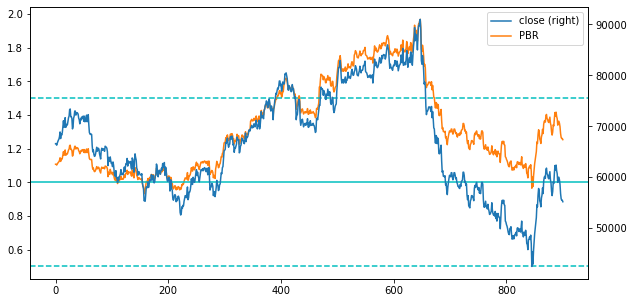

In [15]:
ax = samsung_capital[['close', 'PBR']].plot(secondary_y=['close'], figsize=(10,5))
ax.axhline(1.5, c='c', ls='--')
ax.axhline(1.0, c='c')
ax.axhline(.5, c='c', ls='--')
plt.show()

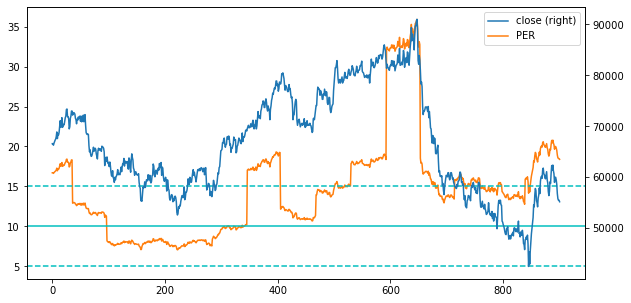

In [13]:
ax = samsung_profit[['close', 'PER']].plot(secondary_y=['close'], figsize=(10,5))
ax.axhline(15, c='c', ls='--')
ax.axhline(10, c='c')
ax.axhline(5, c='c', ls='--')
plt.show()